<a href="https://colab.research.google.com/github/Alois117/AI-Ethics/blob/main/COMPAS_Bias_Audit_AIF360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U gdown
!gdown --id 1f-iIxthOVgmisZL0xKIJsf0ZcGTlj4Sk

!pip install aif360


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1f-iIxthOVgmisZL0xKIJsf0ZcGTlj4Sk
To: /content/compas-scores-two-years.csv
100% 2.55M/2.55M [00:00<00:00, 197MB/s]


In [ ]:
import pandas as pd
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load dataset
df = pd.read_csv("compas-scores-two-years.csv")
df.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
# Keep only the two major races: African-American and Caucasian
df = df[df['race'].isin(['African-American', 'Caucasian'])]

# Encode race: Caucasian (privileged) = 1.0, African-American (unprivileged) = 0.0
df['race'] = df['race'].apply(lambda x: 1.0 if x == 'Caucasian' else 0.0)

# Select relevant numeric fields
df_clean = df[['race', 'age', 'decile_score', 'priors_count', 'two_year_recid']]
df_clean = df_clean.dropna()
df_clean.head()


,race,age,decile_score,priors_count,two_year_recid
1,0.0,34,3,0,1
2,0.0,24,4,4,1
3,0.0,23,8,1,0
6,1.0,41,6,14,1
8,1.0,39,1,0,0


In [ ]:
# Simulate predictions using decile score: >= 5 = High Risk (1.0), < 5 = Low Risk (0.0)
df_clean['predicted'] = df_clean['decile_score'].apply(lambda x: 1.0 if x >= 5 else 0.0)


In [ ]:
# Step 1: Select only the features used for modeling
features = ['race', 'age', 'decile_score', 'priors_count']

# Step 2: Build two identical feature datasets
X = df_clean[features].copy()

# Step 3: Create label arrays (true and predicted)
y_true = df_clean['two_year_recid'].astype(float).values
y_pred = df_clean['decile_score'].apply(lambda x: 1.0 if x >= 5 else 0.0).astype(float).values

# Step 4: Create two identical DataFrames and assign labels
df_true = X.copy()
df_true['two_year_recid'] = y_true

df_pred = X.copy()
df_pred['two_year_recid'] = y_pred

# Step 5: Convert to AIF360 BinaryLabelDatasets
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

dataset_true = BinaryLabelDataset(
    df=df_true,
    label_names=['two_year_recid'],
    protected_attribute_names=['race']
)

dataset_pred = BinaryLabelDataset(
    df=df_pred,
    label_names=['two_year_recid'],
    protected_attribute_names=['race']
)

# Step 6: Define groups
privileged_groups = [{'race': 1.0}]
unprivileged_groups = [{'race': 0.0}]

# Step 7: Compute fairness metrics
metric = ClassificationMetric(
    dataset_true,
    dataset_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Step 8: Print metrics
print("Fairness Metrics Results")
print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())
print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
print("Average Odds Difference:", metric.average_odds_difference())
print("False Positive Rate Difference:", metric.false_positive_rate_difference())


Fairness Metrics Results
Statistical Parity Difference: 0.2402002032197631
Disparate Impact: 1.6902240031631133
Equal Opportunity Difference: 0.19737296377737334
Average Odds Difference: 0.20564895979925066
False Positive Rate Difference: 0.21392495582112797


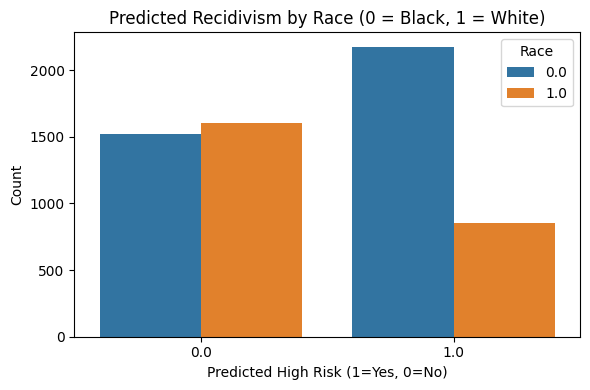

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(data=df_clean, x='predicted', hue='race')
plt.title("Predicted Recidivism by Race (0 = Black, 1 = White)")
plt.xlabel("Predicted High Risk (1=Yes, 0=No)")
plt.ylabel("Count")
plt.legend(title="Race")
plt.tight_layout()
plt.show()


### COMPAS Bias Audit Report

This project audited the COMPAS recidivism dataset using IBM’s AI Fairness 360 toolkit, focusing on racial bias between African-American (unprivileged) and Caucasian (privileged) individuals.

Using the COMPAS `decile_score` (a risk score from 1 to 10), we simulated a classifier by labeling individuals with a score ≥5 as high-risk. We compared these predicted outcomes to the actual two-year recidivism data.

### Fairness Metrics Summary:
- **Statistical Parity Difference**: +0.24  
- **Disparate Impact**: 1.69  
- **Equal Opportunity Difference**: +0.20  
- **Average Odds Difference**: +0.21  
- **False Positive Rate Difference**: +0.21  

These metrics show that African-Americans are more likely to be labeled high-risk than Caucasians, even when the true outcomes do not justify it. The false positive rate difference of 21% suggests a systemic bias — African-Americans are more often wrongly predicted to reoffend.

### Recommendations:
- Apply **fairness-aware algorithms** like reweighing or adversarial debiasing during model training.
- Consider **post-processing techniques** (e.g., calibrated equalized odds) to adjust decision thresholds by group.
- Regularly **audit models** for fairness, especially in high-stakes applications such as criminal justice.

This analysis reinforces the importance of ethical AI practices and highlights how historical biases can persist in modern predictive systems. Tools like AIF360 help make such disparities measurable and actionable.
